# Size Sorts and p-Hacking
2023/11/14 石宛青&王梦涵

分工情况：两人各自完成代码，一起讨论解决遇到的问题

##### 本章主要内容：

1.探索公司规模变量的分布情况

2.讨论上市交易所、权重规则行业和时期对规模溢价的影响

3.p-hacking练习(稳健性测试)


In [1]:
import pandas as pd
import numpy as np

import sqlite3
import statsmodels.api as sm
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import percent_format, date_format
import matplotlib.pyplot as plt

import itertools
from joblib import Parallel, delayed, cpu_count

与前几章相比，我们介绍了itertools，它是Python标准库的一个组件，为使用迭代器提供了快速、节省内存的工具

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1. 数据准备

In [3]:
tidy_finance = sqlite3.connect(database="data/tidy_finance_python.sqlite")

In [4]:
crsp_monthly = pd.read_sql_query(sql='SELECT * FROM crsp_monthly',
                                 con=tidy_finance,
                                 parse_dates={"month"})

In [5]:
factors_ff3_monthly = pd.read_sql_query(sql='SELECT smb FROM factors_ff3_monthly',
                                        con=tidy_finance)

## 2. 规模分布

##### 本节内容
1. 探索公司规模变量的分布情况
2. 本节创建了三个指标

### 2.1
##### 创建月度指标：跟踪一只股票是否属于最大的x %的公司并将每个类别内的公司进行汇总，然后计算这些类别在总市值中的份额。

In [6]:
## 小于75分位数，mktcap_group为0，75分位数到90分位数mktcap_group为1……，大于99分位数mktcap_group为4
market_cap_concentration  = ( crsp_monthly
                             .get(["month","mktcap"]) ## 只提取自己需要的数据，该行代码可以将时间由12秒左右缩短到3秒左右
                             .groupby("month",group_keys=False)
                             .apply(lambda x: x.assign(mktcap_group = lambda x: np.digitize(x["mktcap"], np.percentile(x["mktcap"], [75, 90, 95, 99]))))
                             .groupby("month",group_keys=False)
                             .apply(lambda x: x.assign(Largest_1percent_of_stocks = ((x["mktcap"][x["mktcap_group"]>=4]).sum()/x["mktcap"].sum()),
                                                       Largest_5percent_of_stocks = ((x["mktcap"][x["mktcap_group"]>=3]).sum()/x["mktcap"].sum()),
                                                       Largest_10percent_of_stocks = ((x["mktcap"][x["mktcap_group"]>=2]).sum()/x["mktcap"].sum()),
                                                       Largest_25percent_of_stocks = ((x["mktcap"][x["mktcap_group"]>=1]).sum()/x["mktcap"].sum()))
                                    .tail(1)
                                   )
                             .melt(id_vars="month",
                                   value_vars=["Largest_1percent_of_stocks", "Largest_5percent_of_stocks",
                                               "Largest_10percent_of_stocks","Largest_25percent_of_stocks"],
                                   var_name="type",
                                   value_name="value")
                             )

In [7]:
market_cap_concentration.sort_values("month").head(10)


,month,type,value
0,1960-02-01,Largest_1percent_of_stocks,0.320526
755,1960-02-01,Largest_5percent_of_stocks,0.543021
2265,1960-02-01,Largest_25percent_of_stocks,0.843401
1510,1960-02-01,Largest_10percent_of_stocks,0.666851
2266,1960-03-01,Largest_25percent_of_stocks,0.845067
1,1960-03-01,Largest_1percent_of_stocks,0.321983
756,1960-03-01,Largest_5percent_of_stocks,0.543685
1511,1960-03-01,Largest_10percent_of_stocks,0.668153
757,1960-04-01,Largest_5percent_of_stocks,0.541507
2267,1960-04-01,Largest_25percent_of_stocks,0.845587


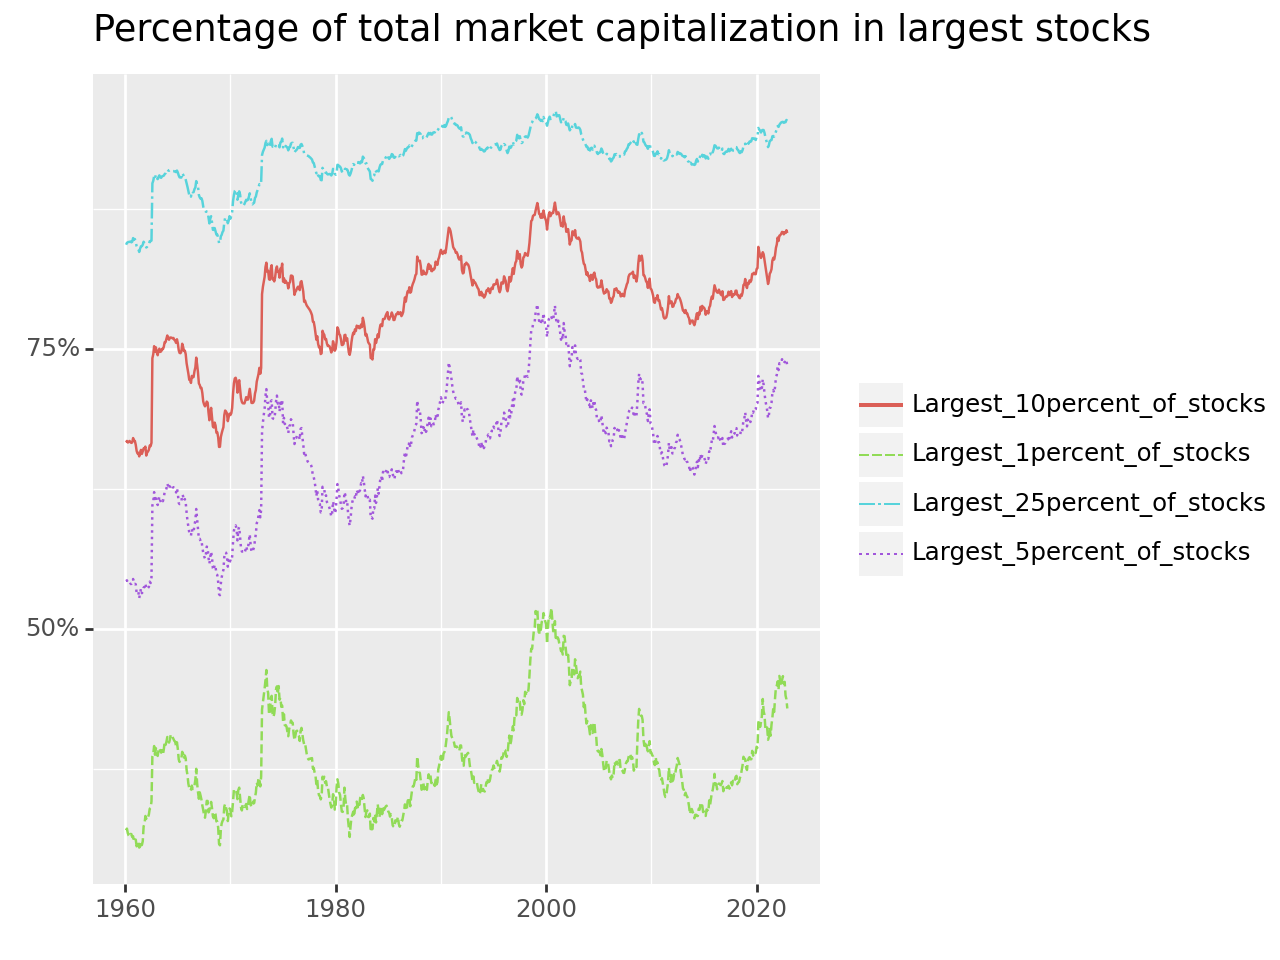

In [8]:
plot_market_cap_concentration = (ggplot(market_cap_concentration, 
                                        aes(x="month", y="value", color="type", linetype="type")) +
                                 geom_line() +
                                 scale_y_continuous(breaks=[0, 0.25, 0.5, 0.75, 1],labels=["0%", "25%", "50%", "75%", "100%"])+
                                 scale_x_datetime(breaks=date_breaks("20 year"), labels=date_format("%Y")) +
                                 labs(x="", y="", color="", linetype="", 
                                      title="Percentage of total market capitalization in largest stocks") +
                                 theme(legend_title=element_blank()))

plot_market_cap_concentration.draw()



##### 结论：
1. 最大的1%的公司覆盖了总市值的50%，而在CRSP中持有25%的最大公司基本上复制了市场投资组合公司
2. 我们使用价值加权基准时，市场上最大的公司支配着许多小公司。

### 2.2
##### 创建一个月度指标,计算不同证券交易所股票市场价值总和占所有股票市场价值总和的比重

In [9]:
market_cap_share = (crsp_monthly
                    .groupby(["month","exchange"],group_keys=False)
                    .aggregate(mktcap=("mktcap", lambda x: sum(x)))
                    .reset_index()
                    .groupby("month",group_keys=False)
                    .apply(lambda x: x.assign(share = x["mktcap"]/(x["mktcap"]).sum())))

In [10]:
market_cap_share.sort_values("month").tail(10)

,month,exchange,mktcap,share
2198,2022-10-01,AMEX,7.650879e+04,0.001974
2199,2022-10-01,NASDAQ,1.675720e+07,0.432289
2204,2022-11-01,NYSE,2.301059e+07,0.567986
2205,2022-11-01,Other,1.345544e+04,0.000332
2202,2022-11-01,AMEX,7.527180e+04,0.001858
2203,2022-11-01,NASDAQ,1.741329e+07,0.429824
2207,2022-12-01,NASDAQ,1.581623e+07,0.416405
2208,2022-12-01,NYSE,2.208722e+07,0.581506
2206,2022-12-01,AMEX,6.600627e+04,0.001738
2209,2022-12-01,Other,1.331011e+04,0.000350


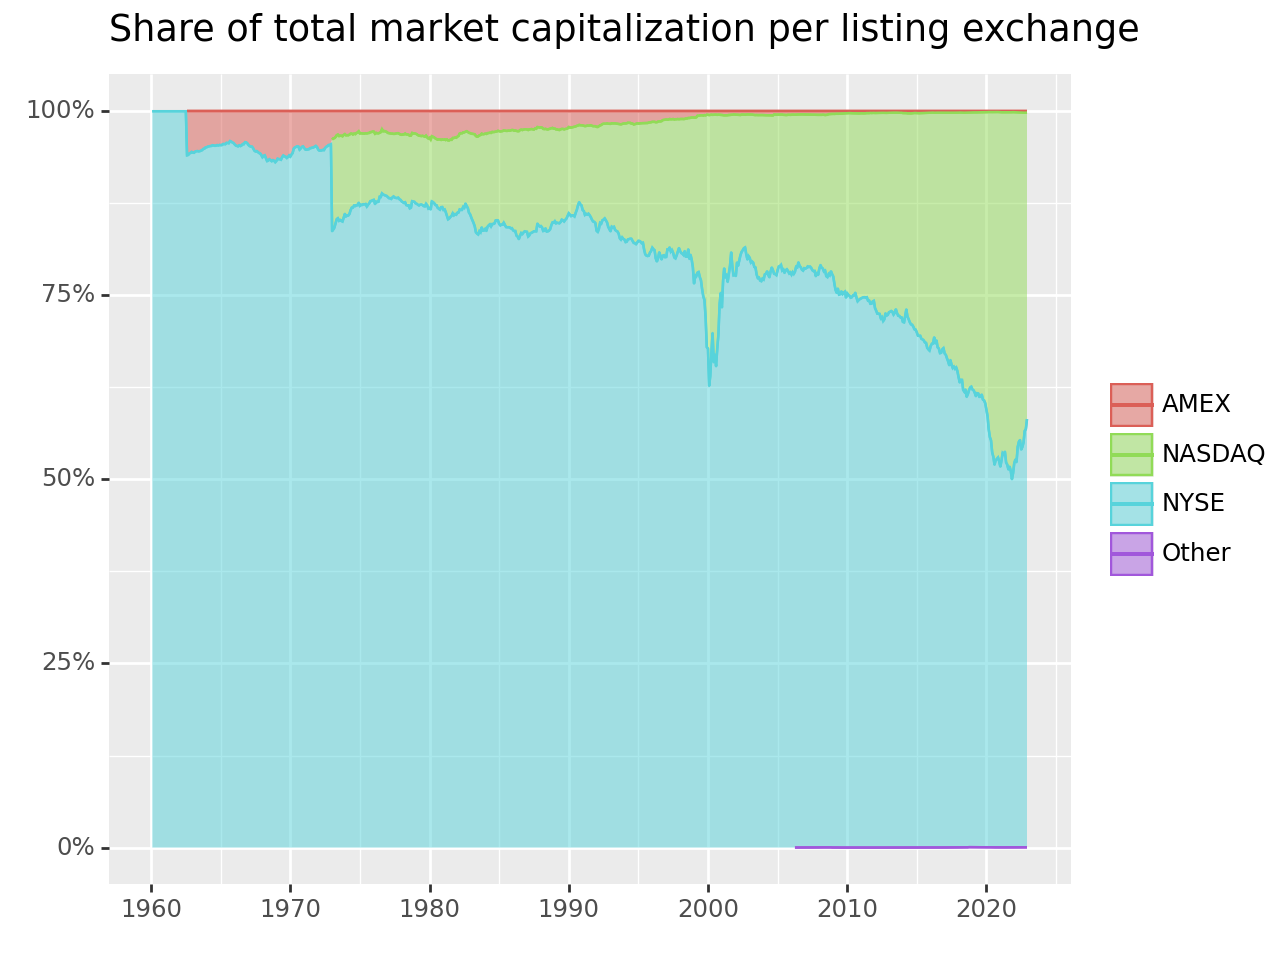

In [11]:
plot_market_cap_share=(ggplot(market_cap_share,
                              aes(x="month",y="share",color="exchange",fill="exchange"))+
                       geom_area(position="stack", stat="identity", alpha=0.5)+
                       geom_line(position="stack") +
                       scale_y_continuous(labels=percent_format()) +
                       scale_x_date(name="", date_labels="%Y") +
                       labs(x="", y="", fill="", color="",
                            title="Share of total market capitalization per listing exchange") +
                       theme(legend_title=element_blank()))

plot_market_cap_share.draw()

##### 结论：
1. 纽约证券交易所(NYSE)过去是、现在仍然是市值最大的上市交易所
2. 纳斯达克(NASDAQ)作为一家上市交易所正逐步获得重要地位
##### 纳斯达克市值在2000年左右的小峰值是什么?
总体来说，纳斯达克的电子化交易平台、更灵活的上市要求以及对高科技和创新公司的友好环境，使其成为许多科技和互联网公司选择在此上市的理想地点。

在2000年，纳斯达克上市公司的市值增长主要与互联网和科技行业的繁荣有关。这一时期被称为 ".com 泡沫"，
其特征是互联网和科技公司的股票价格经历了极端的、不合理的上涨，投资者对这些公司的期望被过度夸大。

## 2.3

##### 创建一个包含更加丰富指标的统计函数，将其应用于每个上市交易所最近一个月的CRSP数据，探索公司规模在上市交易所的分布

In [12]:
def create_summary(data, column_name):
    summary = (data[column_name]
               .agg(mean='mean',
                    std='std',
                    min='min',
                    q05=(lambda x: x.quantile(0.05)),
                    q50=(lambda x: x.quantile(0.50)),
                    q95=(lambda x: x.quantile(0.95)),
                    max='max',
                    n='count')
               )

    return summary

In [13]:
max_month = crsp_monthly["month"].max()

In [14]:
summary1 = (crsp_monthly
            .query("month == @max_month") ##2022-12-01不需要@
            .groupby("exchange")
            .apply(lambda x: create_summary(x, 'mktcap'))
           )

In [15]:
summary2 = (create_summary((crsp_monthly
                            .query("month == @max_month")
                            .assign(exchange=lambda x: "Overall")
                            .groupby("exchange",group_keys=False)),"mktcap"))

In [16]:
pd.concat([summary1,summary2])

,mean,std,min,q05,q50,q95,max,n
exchange,,,,,,,,
AMEX,407.446100,2953.511901,3.397367,5.270655,44.755320,946.698900,3.728891e+04,162.0
NASDAQ,5693.386589,58956.916908,1.174378,7.643100,265.540413,13125.764301,2.066942e+06,2778.0
NYSE,16264.521856,47314.321018,10.782590,112.224015,2804.933485,67882.410119,4.953731e+05,1358.0
Other,13310.108669,NaN,13310.108669,13310.108669,13310.108669,13310.108669,1.331011e+04,1.0
Overall,8835.255874,54584.544264,1.174378,10.211441,482.894609,34101.986878,2.066942e+06,4299.0


##### 结论：

1. 2021年12月在纽交所上市的公司平均规模明显大于在其他交易所上市的公司

2. 纳斯达克上市的公司数量最多

3. 规模最小的公司和规模最大的公司均存在于纳斯达克证券交易所

## 3. 具有灵活断点的单变量规模投资组合

##### 本节内容：

改进分组函数以便在数据子集中确认断点

##### 为什么不使用pd.cut函数进行分组？

assigned_portfolios = (pd.cut(data["mktcap_lag"].dropna(),
                            bins = breakpoints,
                            labels=range(1, len(breakpoints)),
                            include_lowest=True
                            ))
    

如果使用这段代码的话，R语言和python的分组处理有所差别，例如断点为[1,2,3],R语言中会将2分第2组，但时Python会分到第1组，这种区别会导致计算出的规模溢价数据有细微差别
基于此，我们这里的分组函数采用np.digitize函数，但是该函数会将小于最小断点值的数据分到第0组，大于等于最大断点值的数据分到第（x+1）组（假设期望x组），因此将这两部分数据进行更改

In [17]:

def assign_portfolio(data,exchanges,n_portfolios):
    
    breakpoints = np.quantile(data.query("exchange in @exchanges")["mktcap_lag"].dropna(),
                              np.linspace(0, 1, n_portfolios + 1))

    
    assigned_portfolios = np.digitize(data["mktcap_lag"].dropna(), breakpoints)
    

    assigned_portfolios[assigned_portfolios == (n_portfolios+1)] = n_portfolios
    assigned_portfolios[assigned_portfolios == 0] = 1

    return assigned_portfolios


## 4 投资组合的加权方案

##### 本节内容
1. 构造了可以根据不同的投资组合数量、确定断点的证券交易所、组合加权方案以及数据规则计算规模溢价的函数
2. 探索不同的确定断点的证券交易所对于规模溢价的影响

In [18]:
def compute_portfolio_returns(n_portfolios = 10,exchanges = ["NYSE", "NASDAQ", "AMEX"],
                              value_weighted = True,data = crsp_monthly):
    returns = (data
               .groupby("month",group_keys=False)
               .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=exchanges, n_portfolios=n_portfolios)))
               .groupby(["month","portfolio"],group_keys=False)
               .apply(lambda x: np.where(value_weighted,
                                         np.average(x["ret_excess"],weights=x["mktcap_lag"]),
                                         np.mean(x["ret_excess"])))
               .reset_index(name="ret")
               .groupby("month",group_keys=False)
               ## 这里如果不使用np.nanmean()的话，返回的min_size_ret列将会只在portfolio为最大最小处有值，其他地方为NA值
               .apply(lambda x: x.assign(min_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].min()]),
                                         max_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].max()])
                                        )
                     .tail(1))
               
               .assign(size_premium = lambda x: x["min_size_ret"]-x["max_size_ret"]) )["size_premium"].mean()
    ## 注意这里多空组合在最小的公司中是做多的，在最大的公司中是做空的
    return returns

In [19]:
crsp_monthly=crsp_monthly.get(["month","exchange","industry","mktcap","mktcap_lag","ret_excess"])
## 提取需要的数据，可以加快下面代码的运行速度

In [20]:
ret_all = compute_portfolio_returns(n_portfolios=2,
                                    exchanges=["NYSE", "NASDAQ", "AMEX"],
                                    value_weighted=True,
                                    data=crsp_monthly)

In [21]:
ret_all ## 与R结果一模一样

0.0008009346809871956

In [22]:
ret_nyse = compute_portfolio_returns(n_portfolios=2,
                                     exchanges=["NYSE"],
                                     value_weighted=True,
                                     data=crsp_monthly)

In [23]:
ret_nyse


0.0015416572624687354

In [24]:
pd.DataFrame({"Exchanges":["NYSE,NASDAQ&AMEX","NYSE"],
              "Premium":[ret_all*100,ret_nyse*100]})

,Exchanges,Premium
0,"NYSE,NASDAQ&AMEX",0.080093
1,NYSE,0.154166


##### 结论：
1. 如果我们只考虑纽约证券交易所每月形成断点的股票，那么规模溢价将增加接近一倍
2. 原因：纽交所特有的断点更大，整个市场中超过50%的股票在由此产生的小投资组合中，因为纽交所的公司平均规模更大

## 5. P-Hacking and Non-standard Errors

##### 本节内容：
1. 综合探索投资组合的数量、形成断点的证券交易所的选择、权重规则以及行业和时期对规模溢价的影响
2. 非标准误差指的是由于研究人员做出的(合适的)选择而产生的变化
3. p-hacking是指统计分析数据时采用不同的方法直到P<0.05，P-hacking很容易引起假阳生结果

In [25]:
n_portfolios = [2, 5, 10]
exchanges = [["NYSE"], ["NYSE", "NASDAQ", "AMEX"]]
value_weighted = [True, False]
data_filters = [crsp_monthly,
                crsp_monthly.query("industry != 'Finance'"),
                crsp_monthly.query("month < '1990-06-01'"),
                crsp_monthly.query("month >= '1990-06-01'")
               ]
p_hacking_setup = list(itertools.product(n_portfolios, exchanges, value_weighted, data_filters))


In [26]:
p_hacking_setup[0] ## 展示数据，注意data_filters其中包含的是数据，不要写成字符串！！

(2,
 ['NYSE'],
 True,
              month exchange       industry         mktcap     mktcap_lag  \
 0       1986-02-01   NASDAQ  Manufacturing      11.960000      16.100000   
 1       1986-03-01   NASDAQ  Manufacturing      16.330000      11.960000   
 2       1986-04-01   NASDAQ  Manufacturing      15.172000      16.330000   
 3       1986-05-01   NASDAQ  Manufacturing      11.793859      15.172000   
 4       1986-06-01   NASDAQ  Manufacturing      11.734594      11.793859   
 ...            ...      ...            ...            ...            ...   
 3326361 2022-08-01   NASDAQ         Public  863615.620800  931110.623250   
 3326362 2022-09-01   NASDAQ         Public  837659.500000  863615.620800   
 3326363 2022-10-01   NASDAQ         Public  718514.868879  837659.500000   
 3326364 2022-11-01   NASDAQ         Public  614814.304763  718514.868879   
 3326365 2022-12-01   NASDAQ         Public  388971.892324  614814.304763   
 
          ret_excess  
 0         -0.262443  
 1    

In [27]:
n_cores = cpu_count() - 1

In [28]:
p_hacking_results = pd.Series(
  Parallel(n_jobs=n_cores)
  (delayed(compute_portfolio_returns)(x, y, z, w) 
   for x, y, z, w in p_hacking_setup)
)

In [29]:
p_hacking_results[0:10]

0    0.001542
1    0.001586
2    0.002123
3    0.001001
4    0.002074
5    0.002323
6    0.002129
7    0.002022
8    0.000801
9    0.000692
dtype: float64

In [30]:
## data_filters改为字符串，便于观察
data_filters = ["crsp_monthly",
                " crsp_monthly_industry_not_include_Finance",
                " crsp_monthly_month_before_19900601",
                " crsp_monthly_month_after_19900601"]
p_hacking_setup = pd.DataFrame(list(itertools.product(n_portfolios, exchanges, value_weighted, data_filters)))

In [31]:
p_hacking_setup["size_premium"] = p_hacking_results

In [32]:
p_hacking_setup.head(10)

,0,1,2,3,size_premium
0,2,[NYSE],True,crsp_monthly,0.001542
1,2,[NYSE],True,crsp_monthly_industry_not_include_Finance,0.001586
2,2,[NYSE],True,crsp_monthly_month_before_19900601,0.002123
3,2,[NYSE],True,crsp_monthly_month_after_19900601,0.001001
4,2,[NYSE],False,crsp_monthly,0.002074
5,2,[NYSE],False,crsp_monthly_industry_not_include_Finance,0.002323
6,2,[NYSE],False,crsp_monthly_month_before_19900601,0.002129
7,2,[NYSE],False,crsp_monthly_month_after_19900601,0.002022
8,2,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly,0.000801
9,2,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly_industry_not_include_Finance,0.000692


In [33]:
p_hacking_results= (p_hacking_setup
                    .rename(columns={0:"n_portfolio_choice",
                                     1:"exchanges_choice",
                                     2:"value_weighted_choice" ,
                                     3:"data_choice"}))
p_hacking_results.head(10)


,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium
0,2,[NYSE],True,crsp_monthly,0.001542
1,2,[NYSE],True,crsp_monthly_industry_not_include_Finance,0.001586
2,2,[NYSE],True,crsp_monthly_month_before_19900601,0.002123
3,2,[NYSE],True,crsp_monthly_month_after_19900601,0.001001
4,2,[NYSE],False,crsp_monthly,0.002074
5,2,[NYSE],False,crsp_monthly_industry_not_include_Finance,0.002323
6,2,[NYSE],False,crsp_monthly_month_before_19900601,0.002129
7,2,[NYSE],False,crsp_monthly_month_after_19900601,0.002022
8,2,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly,0.000801
9,2,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly_industry_not_include_Finance,0.000692


## 6. 规模溢价变化

##### 本节内容：
1. 绘图显示不同的规模溢价

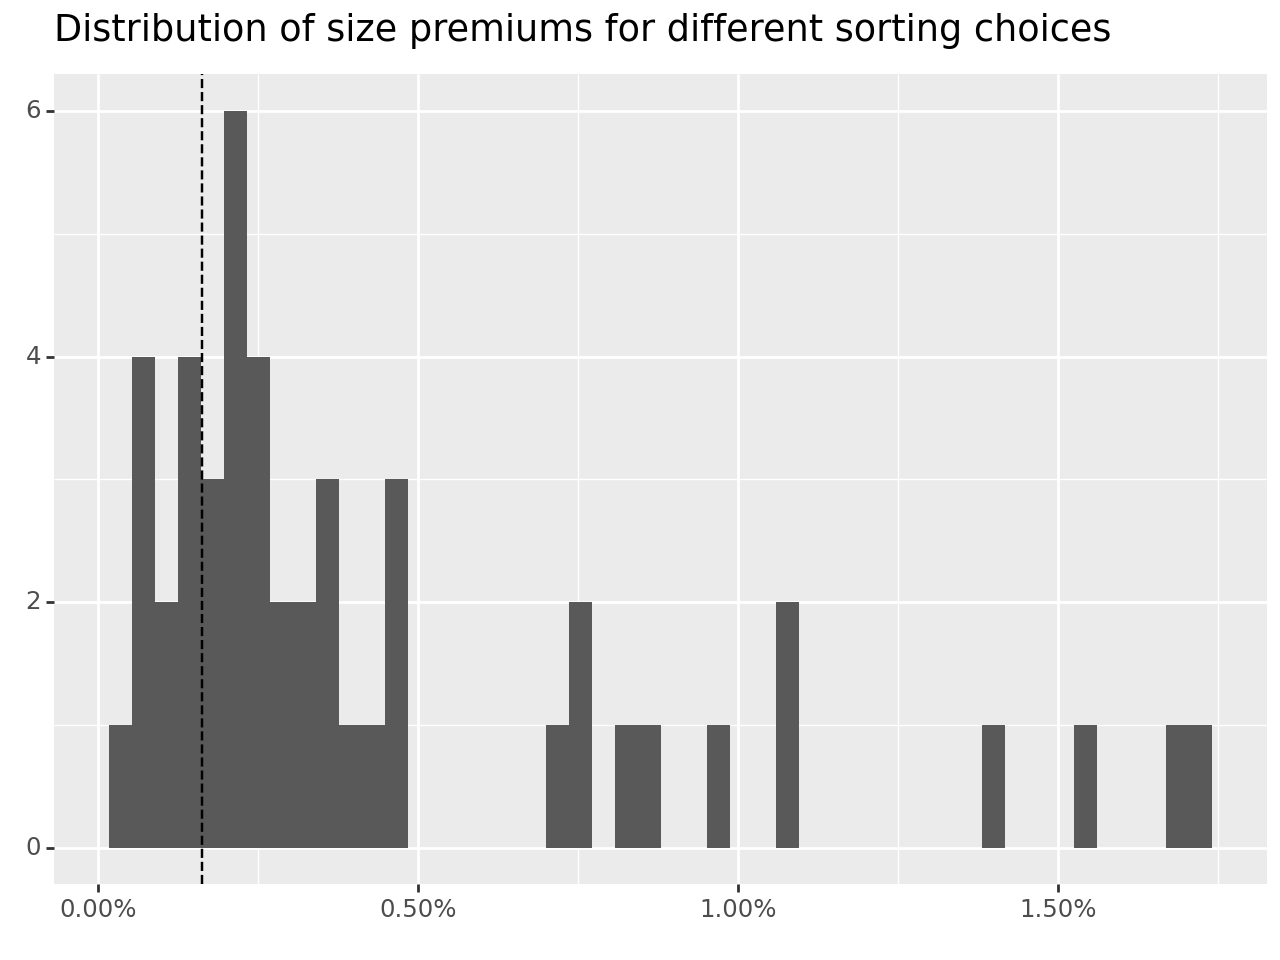

In [34]:
p_hacking_results_figure = (ggplot(p_hacking_results, aes(x="size_premium")) +
                            geom_histogram(bins=len(p_hacking_results)) +
                            scale_x_continuous(labels=percent_format()) +
                            labs(x="", y="",
                                 title="Distribution of size premiums for different sorting choices") +
                            geom_vline(aes(xintercept=factors_ff3_monthly["smb"].mean()), linetype="dashed")
                           )
p_hacking_results_figure.draw()
## 下图还显示了Fama-French SMB(小减去大)平均溢价，我们将其作为虚线垂直线
## 横轴为规模溢价数据，纵轴为频数（某个数据区间内size_premium出现的次数）


##### 结论：
1. 大部分的size_premium低于0.5%
2. 0.25%左右的size_premium出现频率最高

In [35]:
p_hacking_results.sort_values("size_premium",ascending=False).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium
45,10,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly_industry_not_include_Finance,0.017360
47,10,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly_month_after_19900601,0.016949
44,10,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly,0.015485
46,10,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly_month_before_19900601,0.013912
42,10,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly_month_before_19900601,0.010908
41,10,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly_industry_not_include_Finance,0.010778
40,10,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly,0.009553
29,5,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly_industry_not_include_Finance,0.008566
43,10,"[NYSE, NASDAQ, AMEX]",True,crsp_monthly_month_after_19900601,0.008290
31,5,"[NYSE, NASDAQ, AMEX]",False,crsp_monthly_month_after_19900601,0.007701


##### 结论:
1. 发现规模溢价比较大的组合的组合数量选择、形成断点的证券交易所的选择、权重规则选择几乎相同
2. 可以推测数据的行业以及时期对于规模溢价的影响比较小，这与下面的练习4相呼应

## 7. 练习

### 7.1 练习一
1. 哪些证券交易所/行业拥有最大的公司
2. 绘制三个证券交易所随时间变化的平均公司规模
3. 讲述你的结论

In [36]:
## 计算月度指标，筛选出每月规模最大的公司，保留该公司所在的交易所和行业信息
max_size_firm=(crsp_monthly
               .groupby("month", group_keys=False)
               .apply(lambda x: x.assign(max_mktcap = lambda x: x["mktcap"]==x["mktcap"].max()))
               .query("max_mktcap == True")
               .get(["month","exchange","industry","mktcap"])
               .sort_values("month"))

In [37]:
max_size_firm.head(5)

,month,exchange,industry,mktcap
52690,1960-02-01,NYSE,Transportation,19209.38500
52691,1960-03-01,NYSE,Transportation,19021.58375
52692,1960-04-01,NYSE,Transportation,18833.78250
52693,1960-05-01,NYSE,Transportation,19236.21375
52694,1960-06-01,NYSE,Transportation,19155.72750


##### 查看不同证券交易所和行业出现过最大规模公司的频次

In [38]:
(max_size_firm
 .groupby("exchange")
 .apply(lambda x: len(x["exchange"]))
 )

exchange
NASDAQ    156
NYSE      599
dtype: int64

In [39]:
(max_size_firm
 .groupby("industry")
 .apply(lambda x: len(x["industry"]))
 )

industry
Manufacturing     578
Retail              1
Services           41
Transportation    135
dtype: int64

##### 绘图观察每月规模最大的公司出现在哪个证券交易所/行业

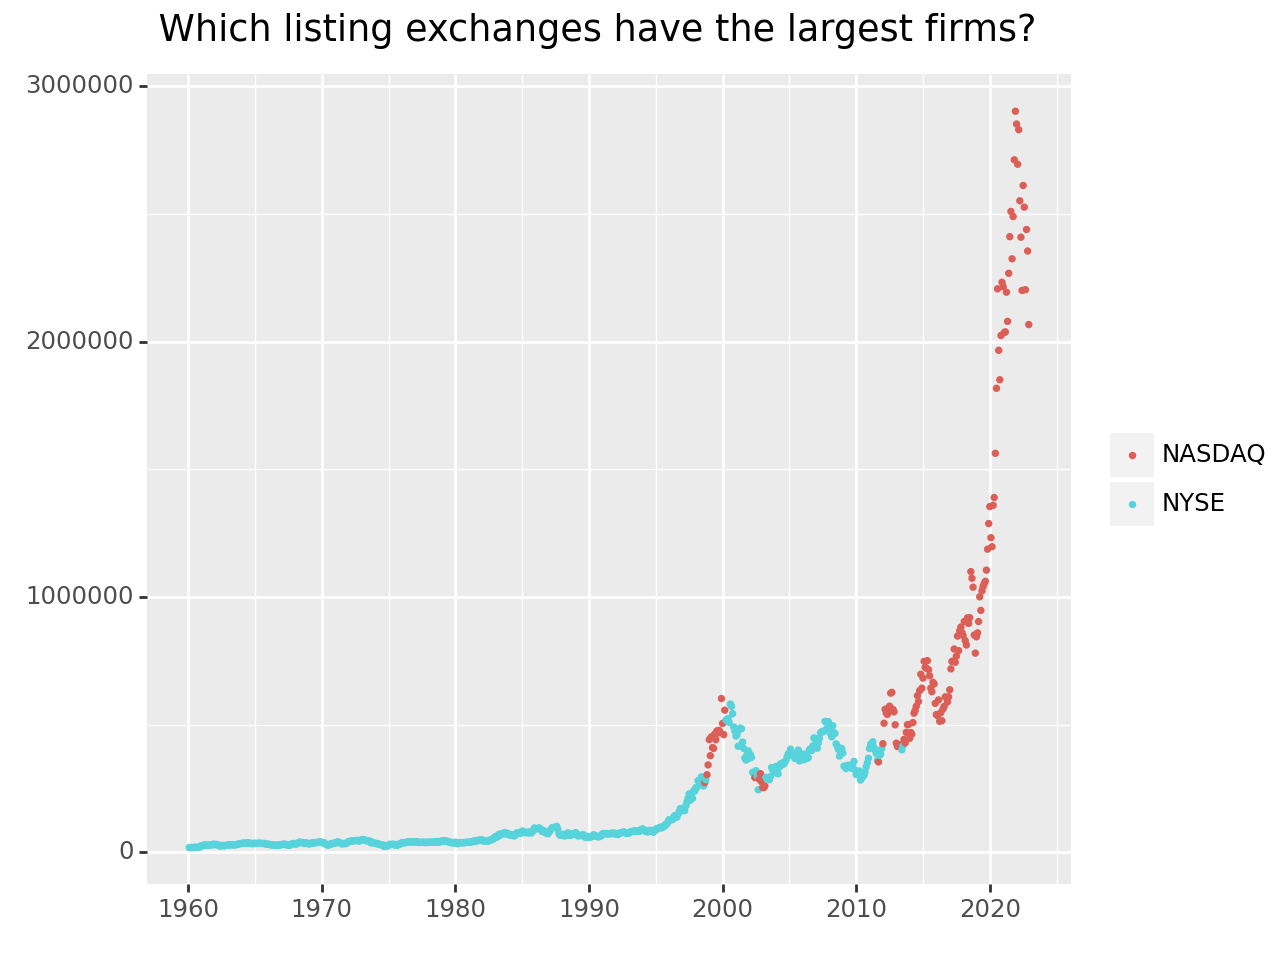

In [40]:
plot_max_size_firm_exchange = (ggplot(max_size_firm,
                                      aes(x="month",y="mktcap",color="exchange"))+
                               geom_point(size=0.5)+
                               scale_x_datetime(breaks=date_breaks("10 year"), labels=date_format("%Y")) +
                               labs(x="", y="", color="", linetype="",
                                    title=" Which listing exchanges have the largest firms?")+
                               theme(legend_title=element_blank()))

plot_max_size_firm_exchange.draw()

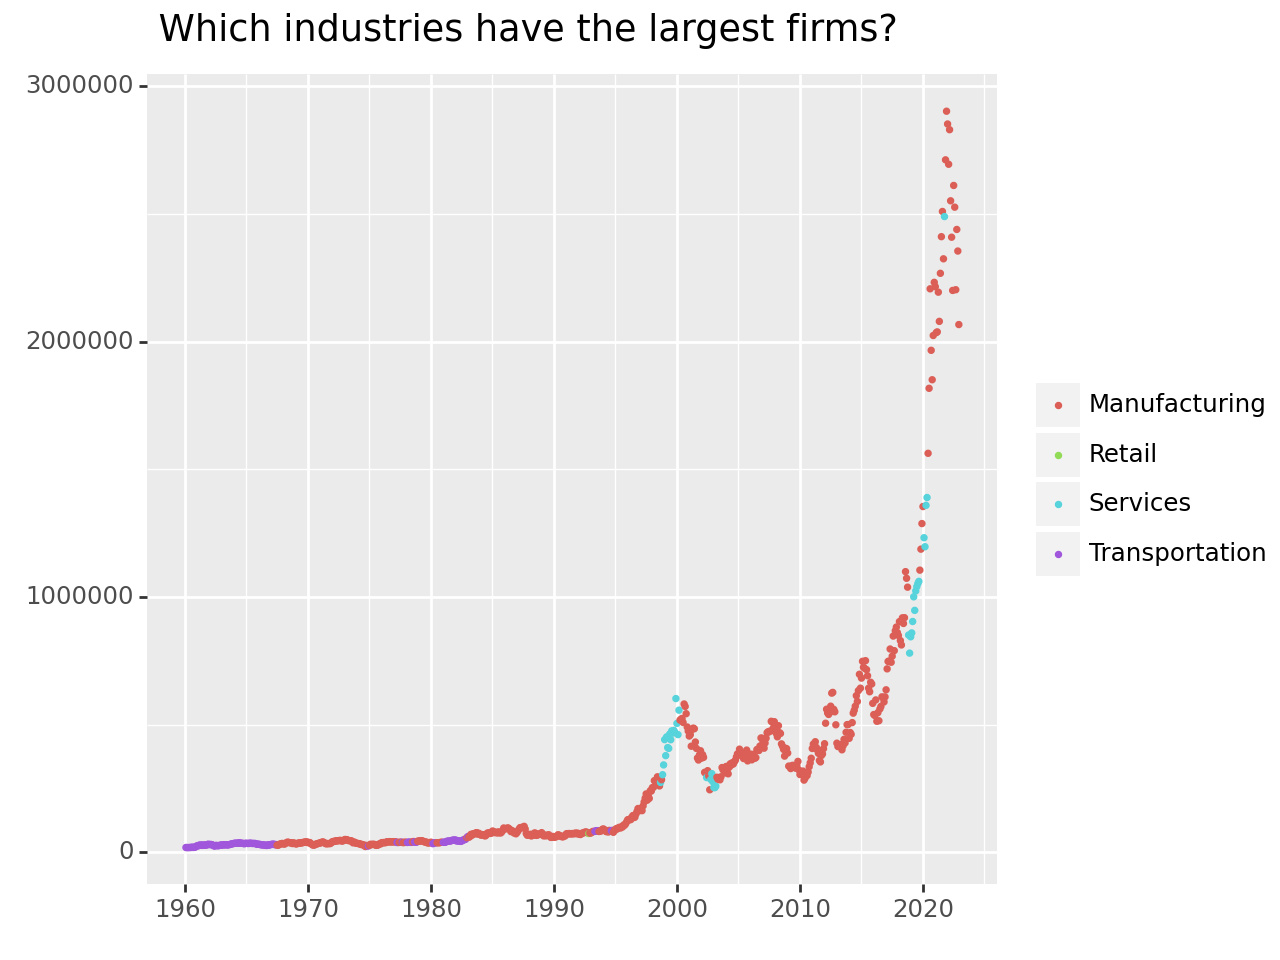

In [41]:
plot_max_size_firm_industry = (ggplot(max_size_firm,
                                      aes(x="month",y="mktcap",color="industry"))+
                               geom_point(size=0.5)+
                               scale_x_datetime(breaks=date_breaks("10 year"), labels=date_format("%Y")) +
                               labs(x="", y="", color="", linetype="", 
                                    title=" Which industries have the largest firms?")+
                               theme(legend_title=element_blank()))


plot_max_size_firm_industry.draw()

##### 结论：

1. 从1960到2022年，大部分时间规模最大的公司都出现在纽约证券交易所，其次是纳斯达克证券交易所，但是从未在美国证券交易所出现过；并且2012年之前规模最大的公司基本出现在纽约证券交易所，而2012年之后基本出现在纳斯达克证券交易所

2. 从1960到2022年，大部分时间规模最大的公司都出现在制造业，其次是运输业；其次，1960-1967年之间，规模最大的公司出现在运输业，其后基本出现在制造业，2000年前后和2020年前后，服务业得到良好发展

##### 不同证券交易所公司市场规模均值

In [42]:
market_cap_mean_per_exchange = (crsp_monthly
                                .groupby(["month","exchange"],group_keys=False)
                                .aggregate(mktcap_mean=("mktcap", lambda x: np.mean(x)))
                                .reset_index())


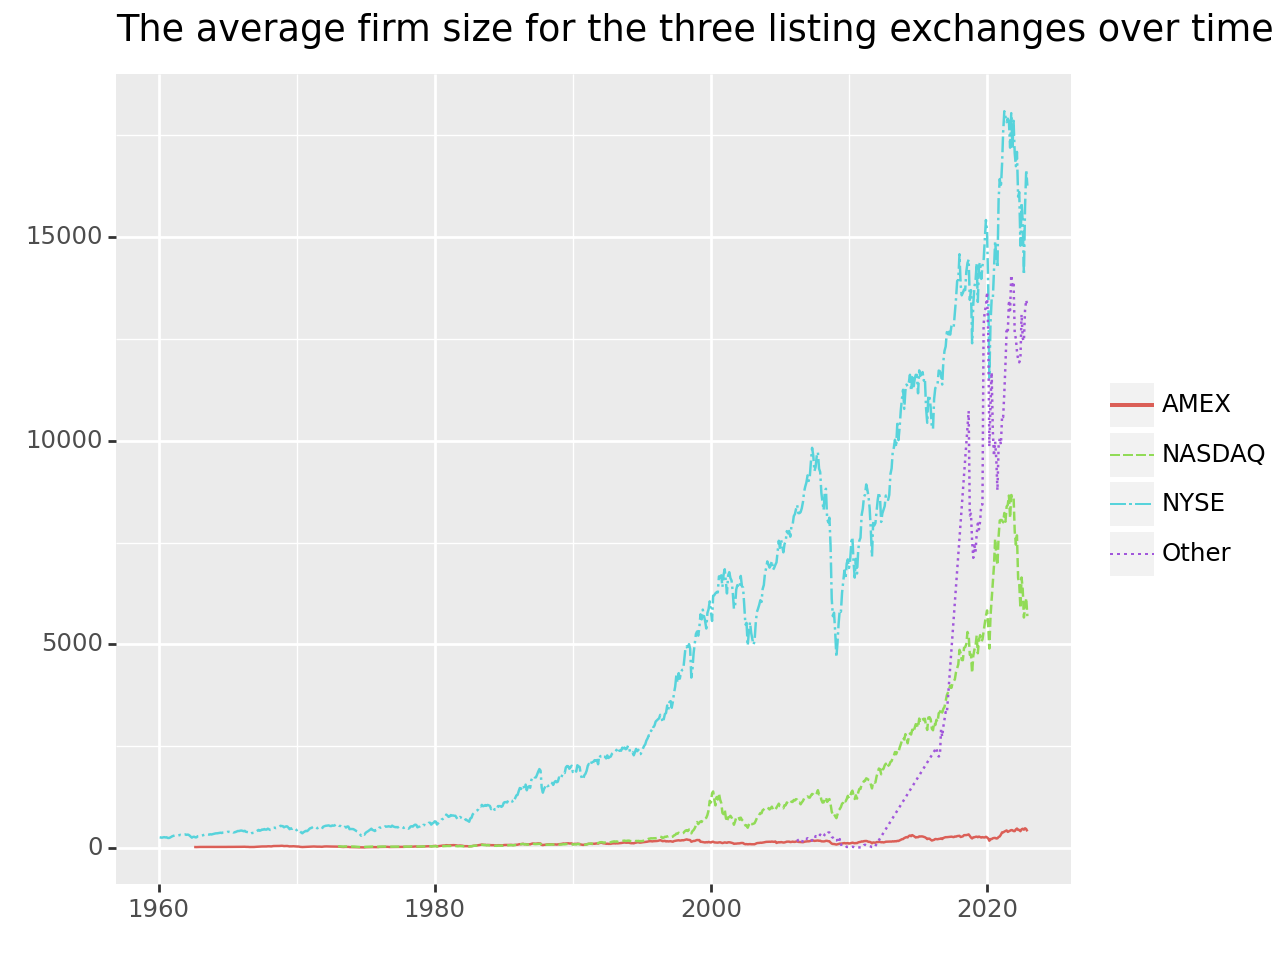

In [43]:
plot_market_cap_mean_per_exchange = (ggplot(market_cap_mean_per_exchange,
                                            aes(x="month",y="mktcap_mean",color="exchange",linetype="exchange"))+
                                     geom_line()+
                                     scale_x_datetime(breaks=date_breaks("20 year"), labels=date_format("%Y")) +
                                     labs(x="", y="", color="", linetype="",
                                          title="The average firm size for the three listing exchanges over time")+
                                     theme(legend_title=element_blank())
                                    )

plot_market_cap_mean_per_exchange.draw()

##### 结论：

1. 除美国证券交易所外所有证券交易所的公司平均规模都呈现出上升趋势

2. 纽约证券交易所的公司平均规模历年来都稳居第一

### 7.2 练习二
1. 绘制10投资组合断点随时间变化的图像
2. 绘制两个极端组合的差值
3. 描述结果


In [44]:
## unstack() 将计算得到的分位数数据从多级索引转换为列，使得每个分位数成为一个列
breakpoints = crsp_monthly.groupby("month")['mktcap_lag'].quantile(q=np.linspace(0, 1, 11)).unstack() ## 
breakpoints.columns = [f"breakpoint{i+1}"for i in range(11)]

In [45]:
crsp_monthly.groupby("month")['mktcap_lag'].quantile(q=np.linspace(0, 1, 11))

month          
1960-02-01  0.0    1.661250e+00
            0.1    1.120838e+01
            0.2    1.963500e+01
            0.3    2.987963e+01
            0.4    4.227650e+01
                       ...     
2022-12-01  0.6    1.073052e+03
            0.7    2.127566e+03
            0.8    4.456576e+03
            0.9    1.359154e+04
            1.0    2.354879e+06
Name: mktcap_lag, Length: 8305, dtype: float64

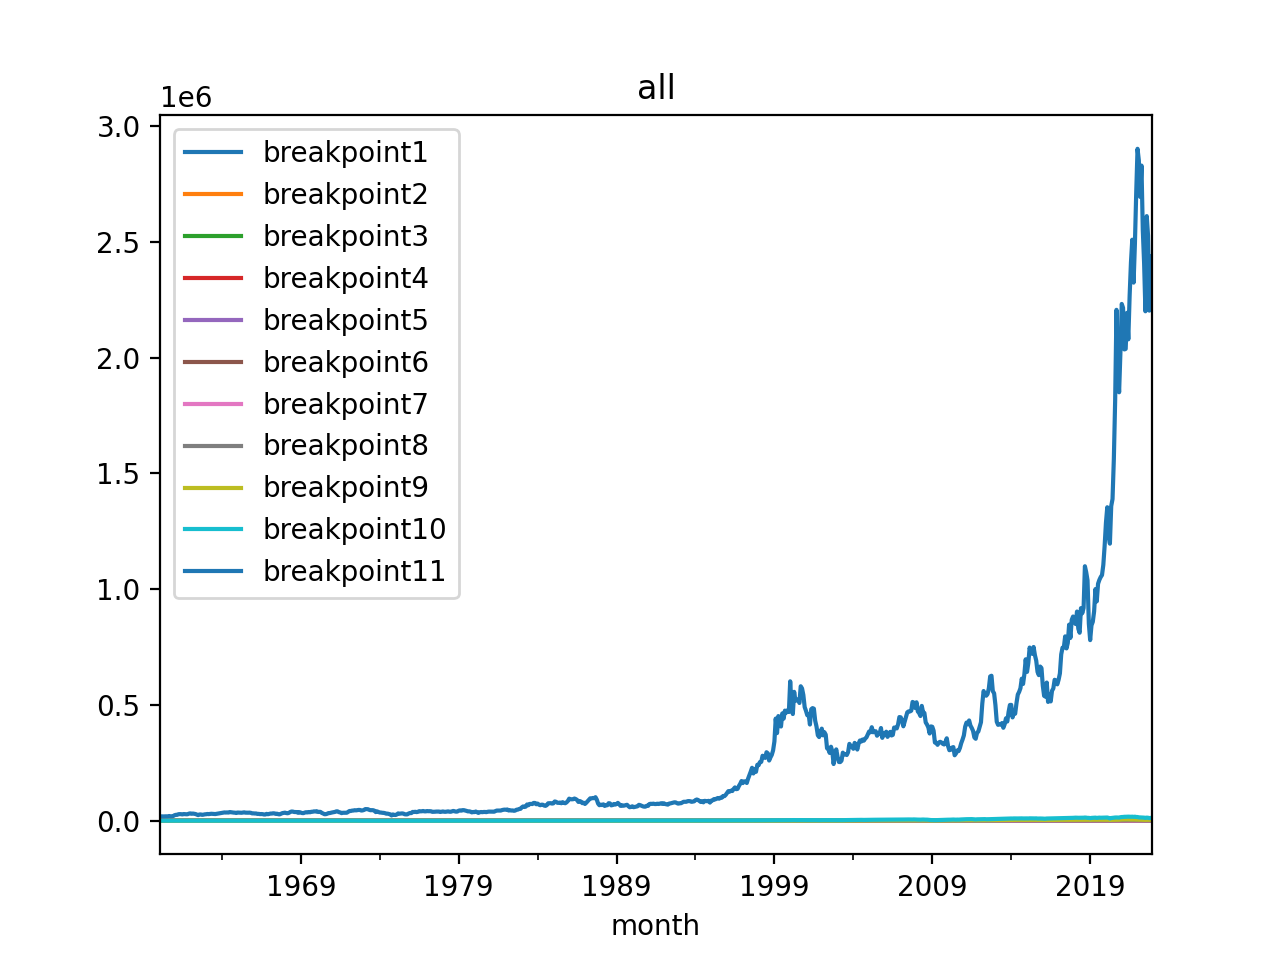

In [46]:
## 因为ggplot函数一张图上只能画四条线，不符合要求
###画在一张图上
breakpoints.plot(y=list(breakpoints.columns[:]), title='all')
plt.show()

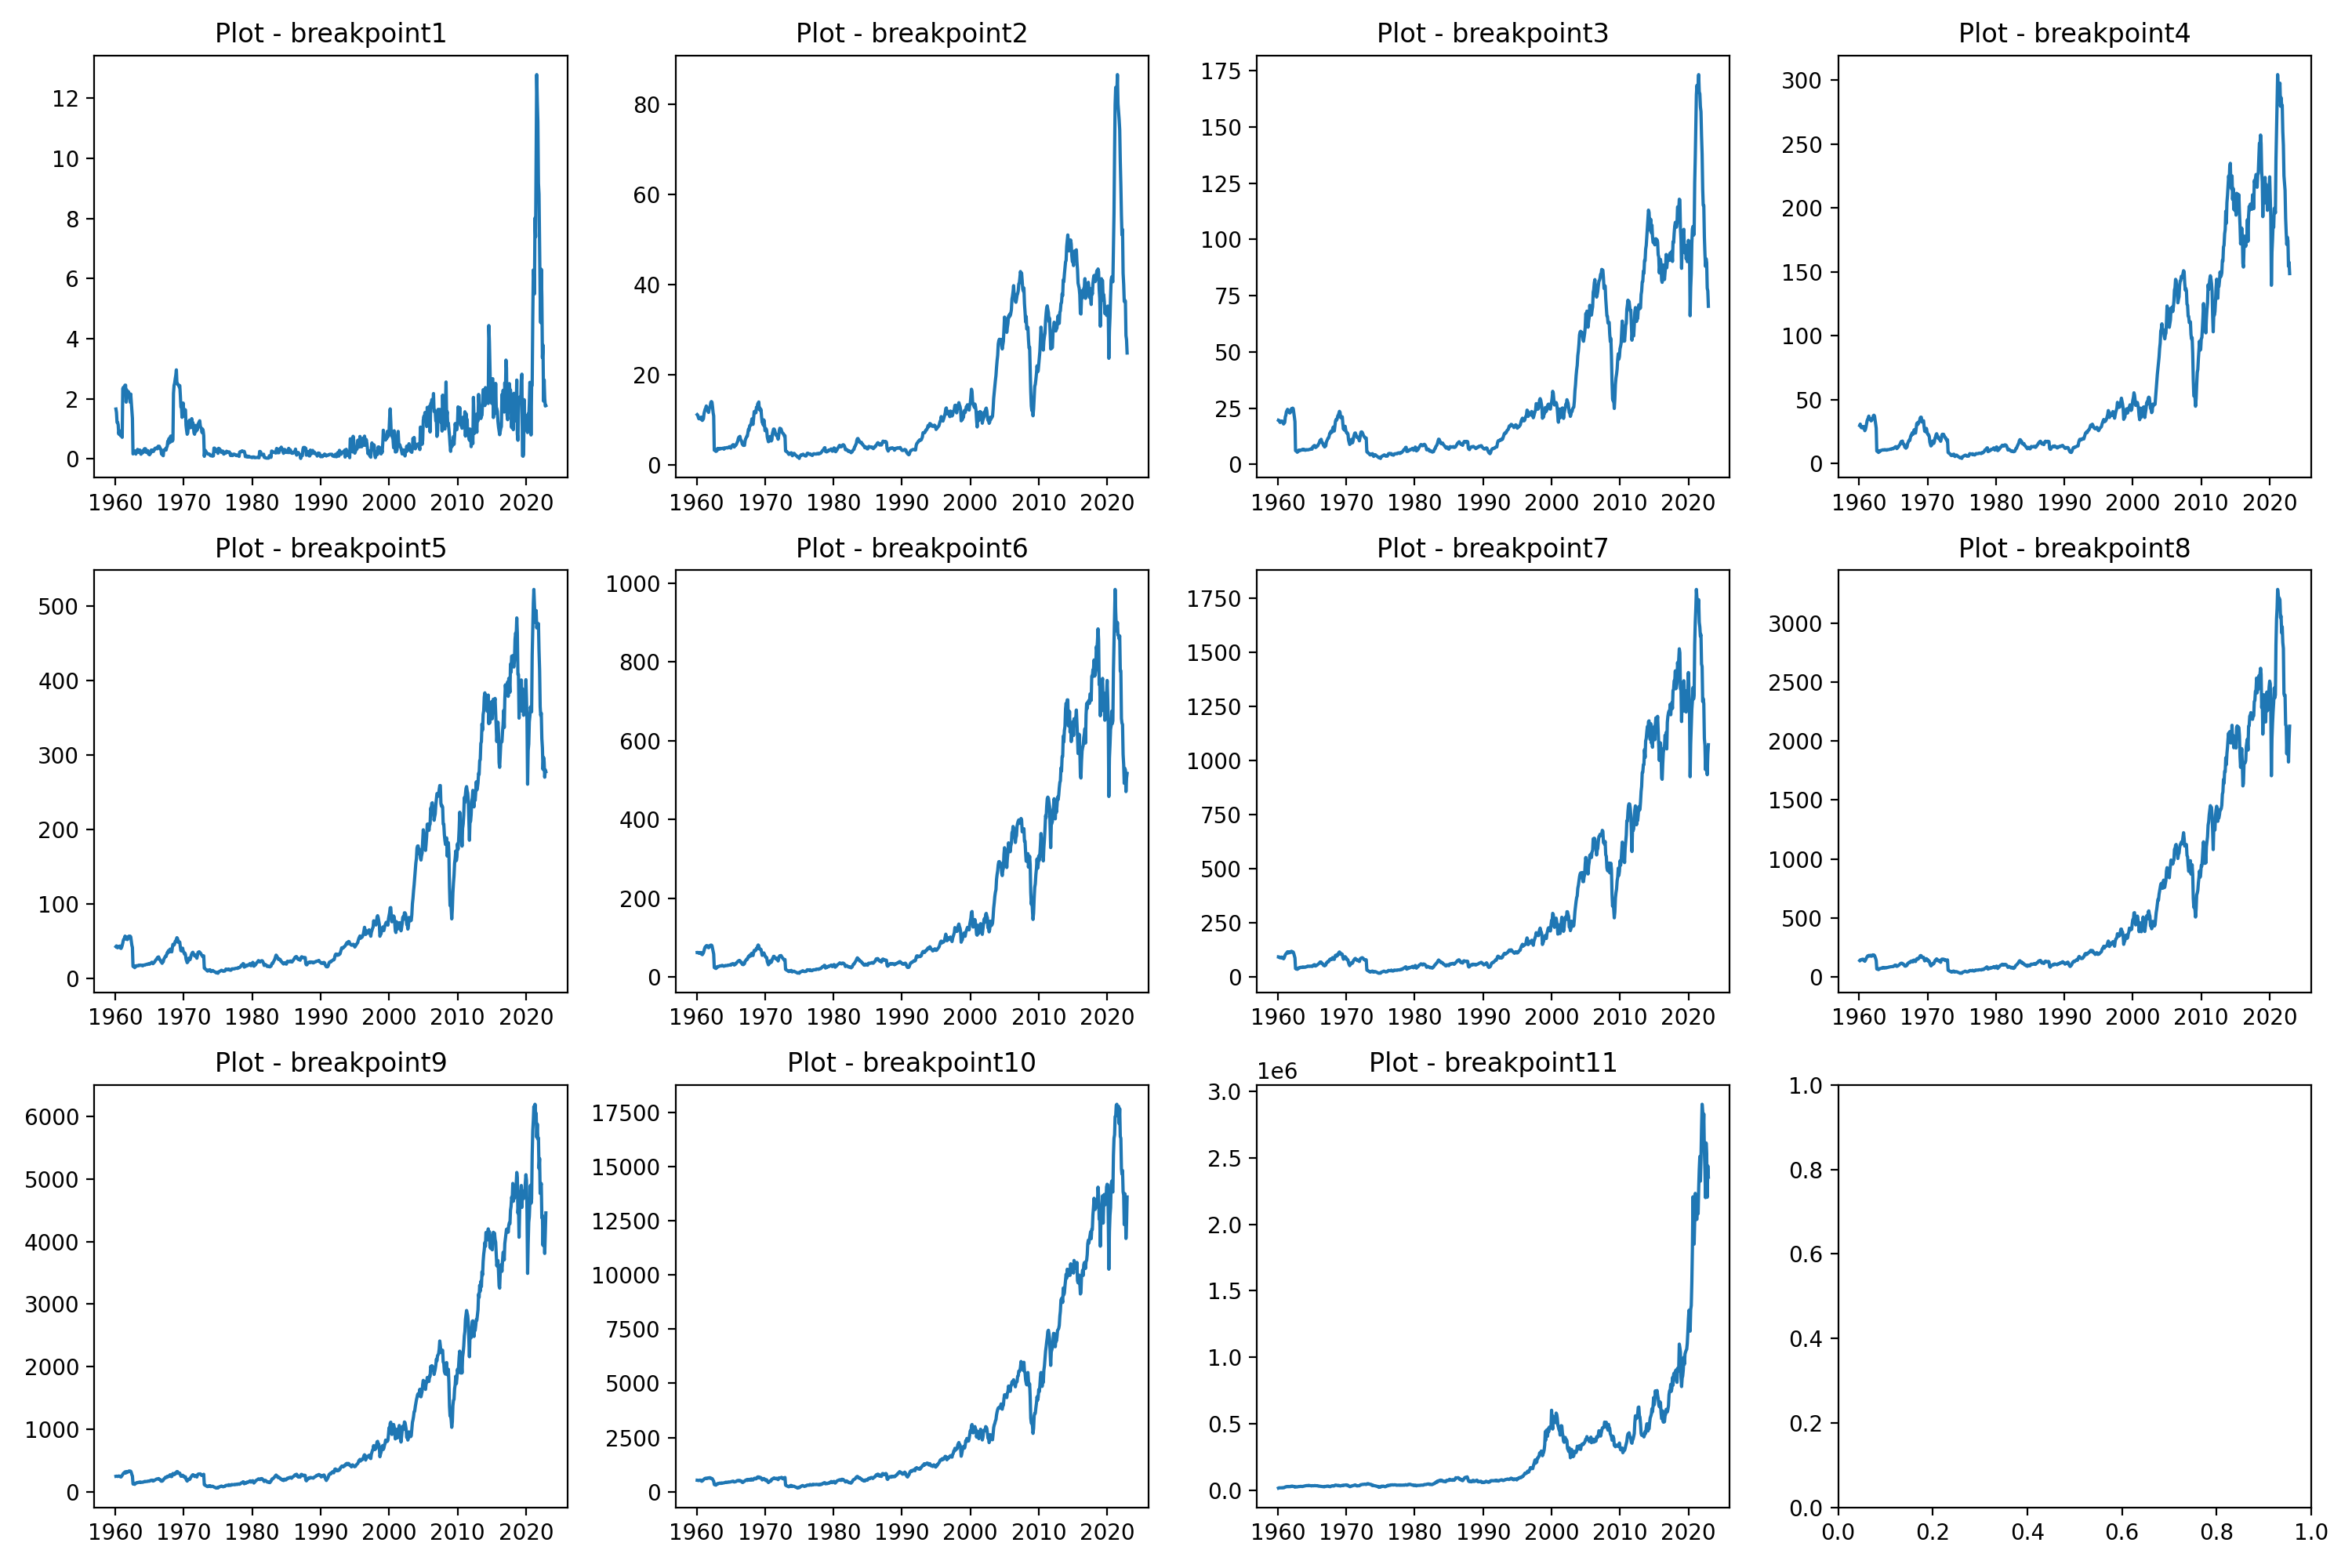

In [47]:
## 因为不同断点之间数据量级相差太大，因此分开绘制
## 分为子图
fig, axs = plt.subplots(3, 4, figsize=(15, 10))
## 将子图网格展平为一个一维数组
axs = axs.flatten()
## 遍历breakpoints的每一列
for i, column in enumerate(breakpoints.columns[:]):
    axs[i].plot(breakpoints.index, breakpoints[column])
    axs[i].set_title(f'Plot - {column}')
## 确保子图之间的间距合适
plt.tight_layout()

plt.show()


##### 结论：
1. 2000年之前，断点的变化和波动幅度都比较小，2000年之后，断点的值开始快速增长
2. 最小值（断点1）的变化比较小，从断点1到11，断点值的变化逐渐平缓，可能是由于小公司更容易受到短期事件的影响，因为较低断点值的波动比较明显

##### 绘制最大最小组之间的区别，即规模溢价

In [48]:
## 选择使用3个证券交易所，市值加权，分组为10分组，数据为原始数据
mkt_portfolios = (crsp_monthly
                  .groupby("month",group_keys=False)
                  .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=["NYSE", "NASDAQ", "AMEX"], n_portfolios=10)))
                  .groupby(["month","portfolio"],group_keys=False)
                  .apply(lambda x: np.average(x["ret_excess"],weights=x["mktcap_lag"]) )
                  .reset_index(name="ret")
                  .groupby("month",group_keys=False)
                  .apply(lambda x: x.assign(min_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].min()]),
                                            max_size_ret = np.nanmean(x["ret"][x["portfolio"]==x["portfolio"].max()])
                              )
                            .tail(1))
                  .assign(size_premium = lambda x: x["min_size_ret"]-x["max_size_ret"])
                  .get(["month","size_premium"]))

In [49]:
mkt_portfolios.head(10)

,month,size_premium
9,1960-02-01,-0.024939
19,1960-03-01,-0.020051
29,1960-04-01,-0.021587
39,1960-05-01,-0.047360
49,1960-06-01,-0.008604
59,1960-07-01,0.008419
69,1960-08-01,0.024674
79,1960-09-01,0.003080
89,1960-10-01,-0.036976
99,1960-11-01,-0.037666


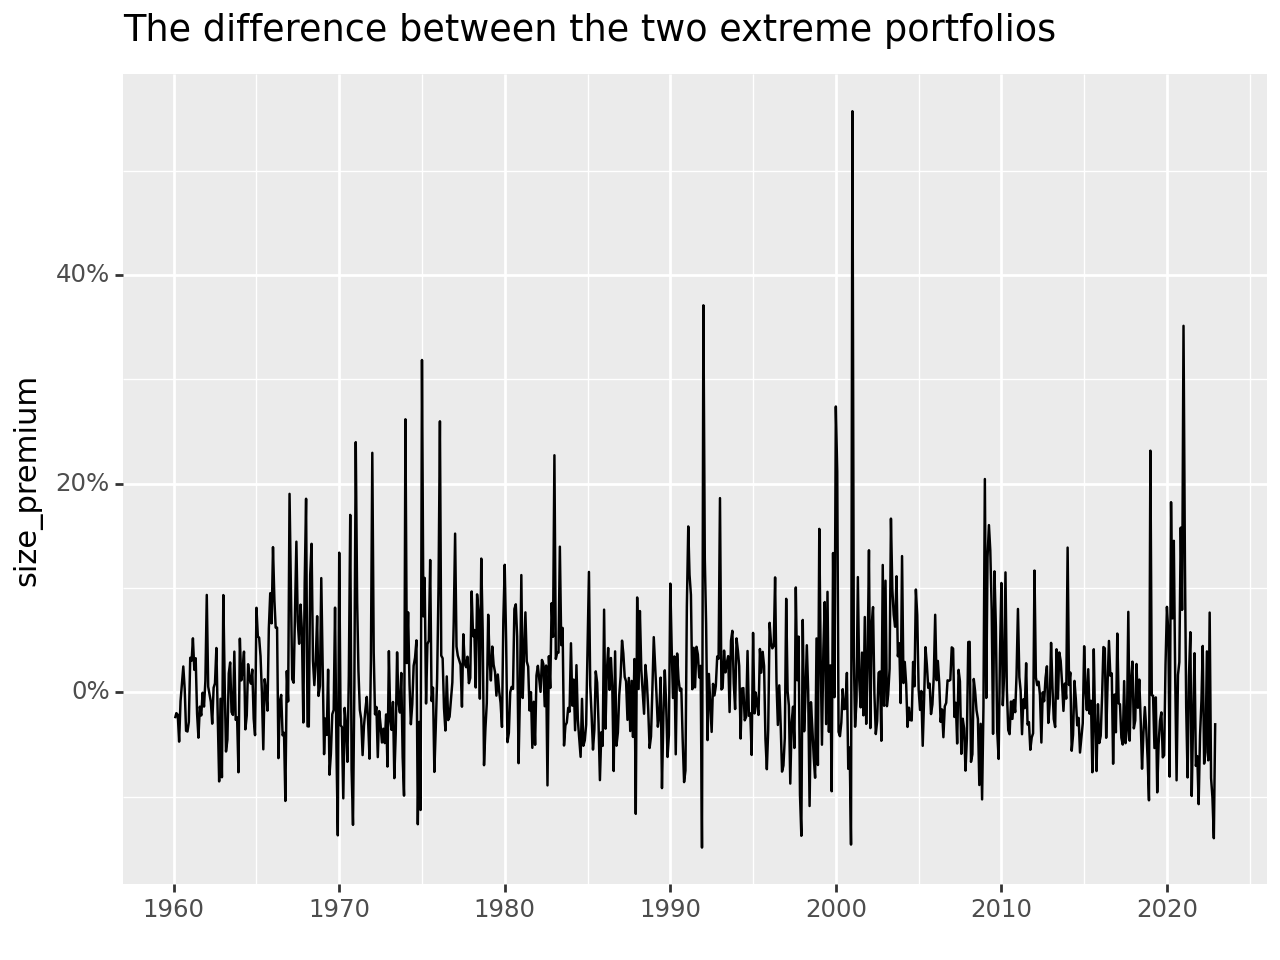

In [50]:
plot_mkt_portfolios = (ggplot(mkt_portfolios,
                              aes(x="month",y="size_premium"))+
                              geom_line()+
                              scale_y_continuous(labels=percent_format()) +
                       scale_x_date(name="", date_labels="%Y") +
                       labs(x="month", y="size_premium",
                            title="The difference between the two extreme portfolios"))

plot_mkt_portfolios.draw()

##### 结论：
1. 规模溢价在2000年左右比较大，我们推测是由于互联网泡沫，股价波动大
2. 规模溢价在2020年左右比较大，我们推测是由于新冠疫情

### 7.3 练习三
1. 更改compute_portfolio_returns()函数，使得函数的输出值为 CAPM alpha或者beta

In [51]:
mkt_excess = pd.read_sql_query('SELECT month, mkt_excess FROM factors_ff3_monthly',
                               con=tidy_finance,
                               parse_dates={"month"})

In [52]:
def compute_portfolio_returns_alpha_beta_t(n_portfolios = 10,exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                           value_weighted = True,data = crsp_monthly):
    returns = (data
            .groupby("month",group_keys=False)
            .apply(lambda x: x.assign(portfolio = assign_portfolio(x,exchanges=exchanges, n_portfolios=n_portfolios)))
            .groupby(["month","portfolio"])
            .apply(lambda x: np.where(value_weighted,
                                      np.average(x["ret_excess"],weights=x["mktcap_lag"]),
                                      np.mean(x["ret_excess"])))
            .reset_index(name="ret")
            .assign(ret = lambda x: x["ret"].astype(float))     ## 记得把ret列由object类型转化为float类型，否则无法正常回归
            .pivot(index="month",
                    columns="portfolio",
                    values="ret")     ## 将长数据转化为宽数据方便计算long_short组合
            .reset_index()
            .assign(long_short = lambda x: x[n_portfolios]-x[1])
            .melt(id_vars="month",
                   var_name="type",
                   value_name="ret")      ## 将宽数据转化回长数据方便分组回归计算alpha、beta和t值
            .merge(mkt_excess,
                   how="left",
                   on="month")
            .groupby("type",group_keys=False)
            .apply(lambda x: x.assign(alpha = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).params[0],
                                       alpha_t = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[0],
                                       beta = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).params[1],
                                       beta_t = sm.OLS.from_formula(formula="ret~1+mkt_excess", data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[1],
                                       premium = np.mean(x["ret"]),
                                       t_value = sm.OLS.from_formula(formula="ret ~ 1",data=x).fit(cov_type="HAC", cov_kwds={"maxlags": 6}).tvalues[0]
                                       )
                                       .tail(1)
                           )
            .drop(["month","ret","mkt_excess"], axis=1)
    )
    

    return returns

In [53]:
## 举例说明
compute_portfolio_returns_alpha_beta_t(n_portfolios=10,
                                       exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                       value_weighted=True,
                                       data=crsp_monthly)

,type,alpha,alpha_t,beta,beta_t,premium,t_value
754,1,0.008963,3.430233,1.055322,18.595076,0.014827,4.141220
1509,2,0.000390,0.189843,1.051581,22.137616,0.006233,2.018832
2264,3,-0.000114,-0.066031,1.096273,24.553662,0.005978,2.116003
3019,4,-0.000241,-0.155231,1.145165,28.385242,0.006122,2.258079
3774,5,-0.000623,-0.445079,1.189405,30.793674,0.005986,2.303302
4529,6,-0.000046,-0.037337,1.217512,37.211596,0.006719,2.743342
5284,7,0.000084,0.082090,1.215195,44.234533,0.006836,2.969731
6039,8,0.000424,0.505068,1.184617,47.104010,0.007007,3.247057
6794,9,0.000603,0.962386,1.114449,64.922666,0.006796,3.447614
7549,10,-0.000054,-0.265646,0.958922,167.503780,0.005275,3.251867


In [54]:
compute_portfolio_returns_alpha_beta_t(n_portfolios=5,
                                       exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                       value_weighted=True,
                                       data=crsp_monthly)

,type,alpha,alpha_t,beta,beta_t,premium,t_value
754,1,0.002790,1.283671,1.051985,21.447900,0.008635,2.701510
1509,2,-0.000205,-0.128286,1.126875,27.257322,0.006056,2.206306
2264,3,-0.000270,-0.210612,1.207388,34.994171,0.006439,2.578275
3019,4,0.000305,0.342087,1.195473,46.750219,0.006948,3.154496
3774,5,0.000016,0.133318,0.976855,292.337846,0.005444,3.305511
4529,long_short,-0.002773,-1.220675,-0.075130,-1.458638,-0.003191,-1.347101


In [55]:
compute_portfolio_returns_alpha_beta_t(n_portfolios=2,
                                       exchanges = ["NYSE", "NASDAQ", "AMEX"],
                                       value_weighted=True,
                                       data=crsp_monthly)

,type,alpha,alpha_t,beta,beta_t,premium,t_value
754,1,-0.000020,-0.013003,1.146154,28.603745,0.006349,2.342124
1509,2,0.000014,0.387365,0.995886,1144.763333,0.005548,3.301943
2264,long_short,0.000034,0.021585,-0.150268,-3.682842,-0.000801,-0.479104


##### 结论：
1. 对比发现十分组时alpha_t值才显著

### 7.4 练习四
1. 根据p-hacking练习的结果，探索哪种变量的选择对于规模溢价有最大的影响

In [56]:
p_hacking_results["exchanges_choice"] = p_hacking_results["exchanges_choice"].astype(str)

In [57]:
(p_hacking_results
 .groupby("n_portfolio_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

,size_premium_mean
n_portfolio_choice,
2,0.001769
5,0.003975
10,0.007994


In [58]:
(p_hacking_results
 .groupby("exchanges_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

,size_premium_mean
exchanges_choice,
"['NYSE', 'NASDAQ', 'AMEX']",0.006712
['NYSE'],0.002447


In [59]:
(p_hacking_results
 .groupby("value_weighted_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

,size_premium_mean
value_weighted_choice,
False,0.006044
True,0.003115


In [60]:
(p_hacking_results
 .groupby("data_choice")
 .aggregate(size_premium_mean=("size_premium", lambda x: np.mean(x))))

,size_premium_mean
data_choice,
crsp_monthly_industry_not_include_Finance,0.004926
crsp_monthly_month_after_19900601,0.004114
crsp_monthly_month_before_19900601,0.004823
crsp_monthly,0.004456


##### 结论：
1. 投资组合数量越大，规模溢价越大，投资组合数量为10组时，其规模溢价时投资组合数量为2组的4.5倍左右
2. 如果单独选择纽约证券交易所的股票确定断点，其规模溢价是选择三个证券交易所的股票确定断点的36%左右
3. 不选择市值加权的规模溢价是市值加权规则下的接近2倍
4. 数据时期以及行业选择对规模溢价的影响很小
5. 我们认为投资组合数量的选取对规模溢价的影响最大，确定断点的证券交易所的选择次之，其次是市值加权规则，而数据时期以及行业选择对规模溢价的影响比较小


### 7.5 练习五
1. 探索我们哪种方式计算出的规模溢价与SMB规模溢价的最接近


Fama and French(1993)因子的构造方式可以参考网站：

https://web.archive.org/web/20080916155240/http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html

Fama and French(1993)对于断点的定义可以参考网站：

https://web.archive.org/web/20080906000826/http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/bench_m_buy.html


In [61]:
(factors_ff3_monthly)["smb"].mean()

0.0016248677248677248

In [62]:
p_hacking_results["ff_smb"]  = (factors_ff3_monthly)["smb"].mean()

In [63]:
(p_hacking_results
 .assign(difference = lambda x: abs(x["ff_smb"]-x["size_premium"]))
 .sort_values("difference")).head(10)

,n_portfolio_choice,exchanges_choice,value_weighted_choice,data_choice,size_premium,ff_smb,difference
27,5,"['NYSE', 'NASDAQ', 'AMEX']",True,crsp_monthly_month_after_19900601,0.001659,0.001625,0.000034
1,2,['NYSE'],True,crsp_monthly_industry_not_include_Finance,0.001586,0.001625,0.000038
33,10,['NYSE'],True,crsp_monthly_industry_not_include_Finance,0.001668,0.001625,0.000044
32,10,['NYSE'],True,crsp_monthly,0.001670,0.001625,0.000045
0,2,['NYSE'],True,crsp_monthly,0.001542,0.001625,0.000083
16,5,['NYSE'],True,crsp_monthly,0.001485,0.001625,0.000140
17,5,['NYSE'],True,crsp_monthly_industry_not_include_Finance,0.001401,0.001625,0.000224
7,2,['NYSE'],False,crsp_monthly_month_after_19900601,0.002022,0.001625,0.000397
4,2,['NYSE'],False,crsp_monthly,0.002074,0.001625,0.000449
10,2,"['NYSE', 'NASDAQ', 'AMEX']",True,crsp_monthly_month_before_19900601,0.001141,0.001625,0.000484


##### 结论：
分组为5组，确定断点的证券交易所为纽约证券交易所、纳斯达克证券交易所和美国证券交易所、加权规则为市值加权、数据为1990年6月一日之后的组合产生的规模溢价与与Fama French规则计算出的市场溢价最接近

## 附录：数据分区——digitize，cut，qcut，quantile函数

In [64]:
## 选择一期数据举例，选择2022-09-01这一期，以为该期数据有公司规模等于断点50%分位数，方便观察函数之间的区别
## 把确认断点的证券交易所设置为纽约证券交易所，这样方便观察当数据小于最大或者最小断点时各个函数的分组情况
example = crsp_monthly.query("month=='2022-09-01'").get(["exchange","mktcap_lag"])
breakpoints_example = np.quantile(example.query("exchange=='NYSE'")["mktcap_lag"],q=np.linspace(0, 1, 3))
breakpoints_example

array([2.16475436e+01, 2.70326000e+03, 4.85772469e+05])

### digitize函数
该函数主要用于将一组数据进行分组

#### 参数
1. x：分箱时输入的数组，必须为一维数组
2. bins： 标量序列，分区的依据，注意bins内的数据一定要是降序或者升序的数据，不能是一堆无序数据
3. right: 间隔是否包含最右，默认值为False
#### 返回值
各个数据所在的区间或者分组

In [65]:
## 返回值为每个值所属区间的索引
digitize_indices1=np.digitize(example["mktcap_lag"],breakpoints_example) 
digitize_indices2=np.digitize(example["mktcap_lag"],breakpoints_example,right=True) 

In [66]:
example["digitize_group1"] = digitize_indices1
example["digitize_group2"] = digitize_indices2

In [67]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag <= @breakpoints_example[0]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2
564541,NASDAQ,2.630494,0,0
704585,NASDAQ,3.189983,0,0
457371,NASDAQ,4.255020,0,0
2875035,NASDAQ,5.142257,0,0
365560,NASDAQ,5.161500,0,0
...,...,...,...,...
593083,NASDAQ,21.518000,0,0
3245139,NASDAQ,21.523050,0,0
585941,NASDAQ,21.532559,0,0
534412,AMEX,21.628650,0,0


In [68]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况(没有等于断点)
example.query("mktcap_lag == @breakpoints_example[1]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2
476610,NYSE,2703.26,2,1


In [69]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag >= @breakpoints_example[2]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2
3299032,NYSE,4.857725e+05,3,2
3174059,NASDAQ,6.488871e+05,3,3
373493,NASDAQ,6.726915e+05,3,3
3326362,NASDAQ,8.636156e+05,3,3
2834767,NASDAQ,1.291476e+06,3,3
14155,NASDAQ,1.950015e+06,3,3
376552,NASDAQ,2.526644e+06,3,3


In [70]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.assign(difference=lambda x: x["digitize_group1"]!=x["digitize_group2"]).query("difference==True")


,exchange,mktcap_lag,digitize_group1,digitize_group2,difference
476610,NYSE,2703.260000,2,1,True
3113828,NYSE,21.647544,1,0,True
3299032,NYSE,485772.469376,3,2,True


#### 总结
1. digitize函数默认把小于最小断点的数据分为第0组
2. 断点之间的默认分组方式为左闭右开，即第x组区间为[breakpoints[x-1],breakpoints[x])，设置right=True之后变为左开右闭区间
3. digitize函数默认把小于最小断点的数据分为第len(breakpoints)组，即(n_portfolios+1)组


### cut函数
主要用于将一组数据进行分区
#### 参数
1. x：分箱时输入的数组，必须为一维数组
2. bins：标量序列，分区的依据，bins内的数据一定要是降序或者升序的数据，不能是一堆无序数据；当bins为整数时，表示几等分
3. labels：标签，分区之后，返回值中各区间可以用标签一一替换显示，如果不指定，返回值以半开区间的分区显示，例如(100,200]
4. right：是否包含bins区间的最右边，默认为True，最右边为闭区间，False则不包含
5. retbins：是否返回bins,当bins作为标量时使用非常有用，默认为False
6. include_lowest：第一个区间是否为左包含(左边为闭区间)，默认为False,表示不包含，True则包含
7. duplicates：可选，默认为{default 'raise', 'drop'}，如果 bin 边缘不是唯一的，则引发 ValueError 或删除非唯一的；使用 duplicates="drop"可以去除断点值重复
8. ordered：默认为True，表示标签是否有序。如果为 True，则将对生成的分类进行排序。如果为 False，则生成的分类将是无序的（必须提供标签）
#### 返回值
各个数据所在的区间或者分组

In [71]:
cut_indices1=pd.cut(example["mktcap_lag"],breakpoints_example,labels=range(1,3)) 
cut_indices2=pd.cut(example["mktcap_lag"],breakpoints_example,labels=range(1,3),include_lowest=True) 
cut_indices3=pd.cut(example["mktcap_lag"],breakpoints_example,labels=range(1,3),right=False) 

In [72]:

example["cut_group1"] = cut_indices1
example["cut_group2"] = cut_indices2
example["cut_group3"] = cut_indices3

In [73]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag <= @breakpoints_example[0]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3
564541,NASDAQ,2.630494,0,0,NaN,NaN,NaN
704585,NASDAQ,3.189983,0,0,NaN,NaN,NaN
457371,NASDAQ,4.255020,0,0,NaN,NaN,NaN
2875035,NASDAQ,5.142257,0,0,NaN,NaN,NaN
365560,NASDAQ,5.161500,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
593083,NASDAQ,21.518000,0,0,NaN,NaN,NaN
3245139,NASDAQ,21.523050,0,0,NaN,NaN,NaN
585941,NASDAQ,21.532559,0,0,NaN,NaN,NaN
534412,AMEX,21.628650,0,0,NaN,NaN,NaN


In [74]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag == @breakpoints_example[1]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3
476610,NYSE,2703.26,2,1,1,1,2


In [75]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag >= @breakpoints_example[2]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3
3299032,NYSE,4.857725e+05,3,2,2,2,NaN
3174059,NASDAQ,6.488871e+05,3,3,NaN,NaN,NaN
373493,NASDAQ,6.726915e+05,3,3,NaN,NaN,NaN
3326362,NASDAQ,8.636156e+05,3,3,NaN,NaN,NaN
2834767,NASDAQ,1.291476e+06,3,3,NaN,NaN,NaN
14155,NASDAQ,1.950015e+06,3,3,NaN,NaN,NaN
376552,NASDAQ,2.526644e+06,3,3,NaN,NaN,NaN


#### 总结
1. cut函数的分组区间默认为左开右闭区间，include_lowest函数可以将分组的最小值包括在内（即第1组改为左闭右闭区间）
2. 设置right=True的话，将分组区间改为左闭右开区间
3. cut函数默认将小于最小断点值和最大断点值的数据全部分组设置为NaN

### qcut函数
主要用于将一组数据进行分区，是cut里面的特例，是以分位数进行分区的
#### 参数
1. x：分箱时输入的数组，只接收1维矩阵或Series
2. q： 整数或数组类型。如果是分位数的整数，例如10用于十分位，4用于四分位；如果是分位数数组，例如[0,0.25,0.5,0.75,1]用于四分位数
3. labels： 数组或者布尔值，默认为none，用于指定每个箱体的标签，如果是数组，长度要与分箱个数一致
4. retbins：是否返回bins,当bins作为标量时使用非常有用，默认为False
5. precision：整数，默认3，存储和显示分箱标签的精度。
6. duplicates：可选，默认为{default 'raise', 'drop'}，如果 bin 边缘不是唯一的，则引发 ValueError 或删除非唯一的；使用 duplicates="drop"可以去除断点值重复
#### 返回值
各个数据所在的区间或者分组

In [76]:
qcut_indices1=pd.qcut(example["mktcap_lag"],q = 2,labels=range(1,3))    ## 注意该函数不能从数据子集确认断点

In [77]:
example["qcut_group"] = qcut_indices1

In [78]:
qcut_breakpoints = np.quantile(example["mktcap_lag"],q=np.linspace(0, 1, 3))
qcut_breakpoints

array([2.63049404e+00, 5.25376791e+02, 2.52664365e+06])

In [79]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag >= @qcut_breakpoints[0]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3,qcut_group
564541,NASDAQ,2.630494e+00,0,0,NaN,NaN,NaN,1
704585,NASDAQ,3.189983e+00,0,0,NaN,NaN,NaN,1
457371,NASDAQ,4.255020e+00,0,0,NaN,NaN,NaN,1
2875035,NASDAQ,5.142257e+00,0,0,NaN,NaN,NaN,1
365560,NASDAQ,5.161500e+00,0,0,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
373493,NASDAQ,6.726915e+05,3,3,NaN,NaN,NaN,2
3326362,NASDAQ,8.636156e+05,3,3,NaN,NaN,NaN,2
2834767,NASDAQ,1.291476e+06,3,3,NaN,NaN,NaN,2
14155,NASDAQ,1.950015e+06,3,3,NaN,NaN,NaN,2


In [80]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag >= @qcut_breakpoints[1]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3,qcut_group
284655,NYSE,5.253768e+02,1,1,1,1,1,1
641525,NASDAQ,5.259150e+02,1,1,1,1,1,2
383717,NYSE,5.261374e+02,1,1,1,1,1,2
582160,NASDAQ,5.268060e+02,1,1,1,1,1,2
654670,NYSE,5.279061e+02,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...
373493,NASDAQ,6.726915e+05,3,3,NaN,NaN,NaN,2
3326362,NASDAQ,8.636156e+05,3,3,NaN,NaN,NaN,2
2834767,NASDAQ,1.291476e+06,3,3,NaN,NaN,NaN,2
14155,NASDAQ,1.950015e+06,3,3,NaN,NaN,NaN,2


In [81]:
## 我们主要观察当数据等于断点时，或者数据小于最大最小断点时的情况
example.query("mktcap_lag >= @qcut_breakpoints[2]").sort_values(["mktcap_lag"])

,exchange,mktcap_lag,digitize_group1,digitize_group2,cut_group1,cut_group2,cut_group3,qcut_group
376552,NASDAQ,2.526644e+06,3,3,NaN,NaN,NaN,2


### 总结
1. 该函数不能实现在数据子集中确认断点，有一定缺陷
2. 该函数的默认分组区间为左开右闭区间，包含最小断点值

### quantile
主要用于将一组数据进行分区,计算沿指定轴的数据的第q个分位数
#### 参数
1. a：输入数组或可以转换为数组的对象
2. q：要计算的分位数或分位数序列，必须在0到1之间（含0和1）
3. axis： 可选，用于计算分位数的一个或多个轴。默认值是沿数组的展平版本计算分位数
#### 返回值
返回第q个分位数或者是一组分位数序列




实际上是上面计算breakpoints的函数，不直接分组